In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.ops import sigmoid_focal_loss
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Use ImageNet normalization for pretrained ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

# FYI: class_to_idx determines 0/1 mapping based on folder names (alphabetical)
print("class_to_idx:", train_dataset.class_to_idx)

# Build model
# (newer torchvision: weights=models.ViT_B_16_Weights.DEFAULT)
model = models.swin_b(pretrained=True).to(device)

# Freeze everything
for p in model.parameters():
    p.requires_grad = False

# Replace classifier with single-logit binary head
in_features = model.head.in_features
model.head = nn.Linear(in_features, 1).to(device)
model.head.requires_grad_(True)

optimizer = optim.Adam(model.head.parameters(), lr=1e-3)
def focal_criterion(logits, targets, alpha=0.25, gamma=2.0):
    # logits: (N,1), targets: float (N,1) with 0/1
    return sigmoid_focal_loss(
        inputs=logits,           # raw logits
        targets=targets,         # 0/1 floats, same shape
        alpha=alpha,
        gamma=gamma,
        reduction="mean"
    )

class_to_idx: {'Negative': 0, 'Positive': 1}


In [5]:
def train_one_epoch():
    model.train()
    running = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # (N,) -> (N,1)

        logits = model(imgs)            # (N,1)
        loss = focal_criterion(logits, labels, alpha=0.25, gamma=2.0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item() * imgs.size(0)
    return running / len(train_loader.dataset)

@torch.no_grad()
def evaluate():
    model.eval()
    correct = 0
    total = 0
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)                 # (N,1)
        preds = (torch.sigmoid(logits).squeeze(1) > 0.5).long()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total

In [6]:
for epoch in range(10):
    train_loss = train_one_epoch()
    acc = evaluate()
    print(f"epoch {epoch+1}: loss {train_loss:.4f} | acc {acc:.3f}")

epoch 1: loss 0.0660 | acc 0.724
epoch 2: loss 0.0475 | acc 0.724
epoch 3: loss 0.0440 | acc 0.737
epoch 4: loss 0.0419 | acc 0.737
epoch 5: loss 0.0410 | acc 0.751
epoch 6: loss 0.0409 | acc 0.779
epoch 7: loss 0.0390 | acc 0.765
epoch 8: loss 0.0387 | acc 0.788
epoch 9: loss 0.0381 | acc 0.774
epoch 10: loss 0.0382 | acc 0.774


              precision    recall  f1-score   support

    Negative     0.7647    0.9936    0.8643       157
    Positive     0.9231    0.2000    0.3288        60

    accuracy                         0.7742       217
   macro avg     0.8439    0.5968    0.5965       217
weighted avg     0.8085    0.7742    0.7162       217

Confusion Matrix:
 [[156   1]
 [ 48  12]]


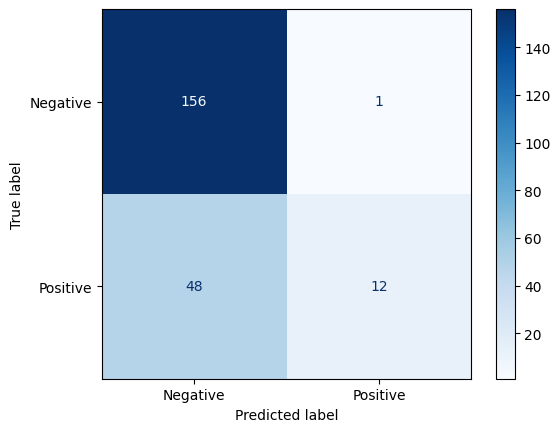

In [8]:
@torch.no_grad()
def evaluate_predictions():
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        probs = torch.sigmoid(logits).squeeze(1)
        preds = (probs > 0.5).long()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    return all_labels, all_preds, all_probs


# ---- Generate reports ----
labels, preds, probs = evaluate_predictions()

# Classification report (precision, recall, f1)
print(classification_report(labels, preds, target_names=train_dataset.classes, digits=4))

# Confusion matrix
cm = confusion_matrix(labels, preds)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap="Blues")
plt.show()
